In [1]:
import sqlite3
import pandas as pd
import matplotlib.dates as dates
from datetime import datetime as dt
import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

import Cdf

In [2]:
params = {'axes.labelsize' : 14, 'axes.titlesize' : 14,
          'font.size' : 14, 'legend.fontsize' : 14,
          'xtick.labelsize' : 14, 'ytick.labelsize' : 14}
plt.rcParams.update(params)

In [3]:
conn = sqlite3.connect('../data/netflix-data-aggregated.db')
df = pd.read_sql_query('select * from traceroute',
                       con=conn, parse_dates=['dtime'])
conn.close()

In [4]:
df

,unit_id,dtime,destination_v4,ttl_v4,rtt_v4,destination_v6,ttl_v6,rtt_v6,delta_ttl,delta_rtt
0,123256,2016-07-22 00:00:00,198.38.119.140,8,16.989,2a00:86c0:119:119::145,9,14.370,-1,2.619
1,123256,2016-07-22 02:00:00,198.38.118.140,8,16.136,2a00:86c0:119:119::142,9,15.826,-1,0.310
2,123256,2016-07-22 04:00:00,198.38.119.149,8,22.194,2a00:86c0:116:116::145,11,20.654,-3,1.540
3,123256,2016-07-22 10:00:00,198.38.119.149,8,20.222,2a00:86c0:116:116::148,11,23.037,-3,-2.815
4,123256,2016-07-22 13:00:00,198.38.117.153,10,23.100,2a00:86c0:118:118::143,9,17.366,1,5.734
...,...,...,...,...,...,...,...,...,...,...
894934,950234,2019-05-03 19:00:00,45.57.38.138,7,9.789,2a00:86c0:2039:2039::142,7,9.648,0,0.141
894935,950234,2019-05-03 20:00:00,45.57.38.144,7,9.947,2a00:86c0:2038:2038::141,6,9.825,1,0.122
894936,950234,2019-05-03 21:00:00,45.57.38.136,7,12.507,2a00:86c0:2038:2038::145,7,13.175,0,-0.668
894937,950234,2019-05-03 22:00:00,45.57.39.143,7,9.526,2a00:86c0:2038:2038::138,6,11.090,1,-1.564


In [5]:
df = df.groupby(['unit_id', 'dtime'], as_index=False
               ).agg({'ttl_v4' : 'median',
                      'ttl_v6' : 'median',}
                    )

In [6]:
df['year'] = df['dtime'].dt.year
df['month'] = df['dtime'].dt.month

In [7]:
by_years = df.groupby('year')

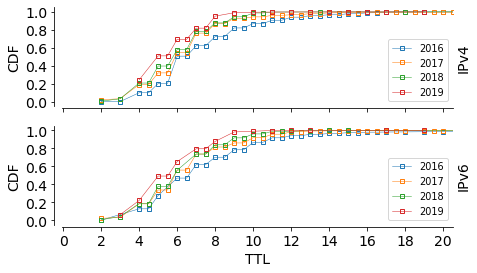

In [8]:
cdf_fig, (cdf_v4_ax, cdf_v6_ax) = plt.subplots(figsize = (7, 4), nrows=2)

cdfs = []

for year, year_df in by_years:
    v4 = Cdf.MakeCdfFromList(year_df['ttl_v4'])
    v6 = Cdf.MakeCdfFromList(year_df['ttl_v6'])

    cdf_v4_ax.plot(v4.xs, v4.ps, label = year, marker = 's',
                   linewidth = 0.5, markersize = 3.5, fillstyle = 'none')
    cdf_v6_ax.plot(v6.xs, v6.ps, label = year, marker = 's',
                   linewidth = 0.5, markersize = 3.5, fillstyle = 'none')

    cdfs.append((year, 'IPv4', v4))
    cdfs.append((year, 'IPv6', v6))

for cdf_ax, version in [(cdf_v4_ax, 'IPv4'), (cdf_v6_ax, 'IPv6')]:
    cdf_ax.set_ylim([-0.05, 1.05])

    cdf_ax.set_xlabel('TTL')
    cdf_ax.set_ylabel('CDF')
    cdf_ax.set_xlim([-.05, 20.5])
    cdf_ax.set_xticks(np.arange(0, 20.5, 2))

    cdf_ax.legend(loc = 'lower right', fontsize = 'x-small')

    yticks = np.arange(0.0, 1.01, 0.2)
    cdf_ax.set_yticks(yticks)
    cdf_ax.grid(False)
    cdf_ax.spines['right'].set_color('none')
    cdf_ax.spines['top'].set_color('none')
    cdf_ax.yaxis.set_ticks_position('left')
    cdf_ax.xaxis.set_ticks_position('bottom')
    cdf_ax.spines['bottom'].set_position(('axes', -0.02))
    cdf_ax.spines['left'].set_position(('axes', -0.02))

    ax1_ = cdf_ax.twinx()
    ax1_.spines['right'].set_color('none')
    ax1_.spines['top'].set_color('none')
    ax1_.spines['left'].set_color('none')
    ax1_.spines['bottom'].set_color('none')
    ax1_.yaxis.set_ticks_position('none')
    ax1_.set_ylabel('%s' % version)
    plt.setp(ax1_.get_yticklabels(), visible = False)

cdf_v4_ax.set_xticklabels('')
cdf_v4_ax.set_xlabel('')
cdf_v4_ax.set_title('')

cdf_fig.savefig('../plots/ttl-by-year.pdf', bbox_inches = 'tight')
plt.show()

In [9]:
for year, version, cdf in cdfs:
    print(year, '\t', version)
    print('----------------')
    skip = max(int(len(cdf.xs)/150), 1)
    for x, p in list(zip(cdf.xs, cdf.ps))[::skip]:
        print('%.2f \t %.5f' % (x, p))
    print('\n===========================\n')

2016 	 IPv4
----------------
2.00 	 0.00072
3.00 	 0.00177
4.00 	 0.09976
4.50 	 0.09978
5.00 	 0.20263
5.50 	 0.20489
6.00 	 0.50673
6.50 	 0.50776
7.00 	 0.62298
7.50 	 0.62309
8.00 	 0.72470
8.50 	 0.72495
9.00 	 0.82112
9.50 	 0.82137
10.00 	 0.86951
10.50 	 0.86953
11.00 	 0.90675
11.50 	 0.90675
12.00 	 0.94096
12.50 	 0.94121
13.00 	 0.95879
13.50 	 0.95888
14.00 	 0.96856
14.50 	 0.96858
15.00 	 0.97996
15.50 	 0.97999
16.00 	 0.98961
16.50 	 0.99034
17.00 	 0.99760
17.50 	 0.99762
18.00 	 0.99879
18.50 	 0.99888
19.00 	 0.99967
20.00 	 0.99976
21.00 	 0.99977
22.00 	 0.99978
23.00 	 0.99986
24.00 	 1.00000


2016 	 IPv6
----------------
2.00 	 0.00174
4.00 	 0.12801
4.50 	 0.12804
5.00 	 0.27601
6.00 	 0.47014
6.50 	 0.47019
7.00 	 0.62075
7.50 	 0.62084
8.00 	 0.70234
8.50 	 0.70265
9.00 	 0.78512
9.50 	 0.78528
10.00 	 0.86703
10.50 	 0.86707
11.00 	 0.91836
11.50 	 0.91847
12.00 	 0.94286
12.50 	 0.94303
13.00 	 0.95655
13.50 	 0.95660
14.00 	 0.96723
14.50 	 0.96797
15.00 